In [1]:
# Criteria Prediction function require 3 inputs (path for tranning dataset, path for testing dataset, and name of
# criteria for which prediction needs to be made)
def Criteria_prediction(Traning_Data_set_Path,Testing_Data_set_Path,Enter_Tag):
    
#   Library Import
    import pandas as pd
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.feature_extraction.text import TfidfVectorizer
    from scipy.sparse import hstack
    from matplotlib import pyplot as plt
    import seaborn as sns
    import eli5
    from xml.dom import minidom
    import os
    from tqdm import tqdm
    import pandas as pd
    from xml.dom import minidom
    import os
    from tqdm import tqdm
    import matplotlib.pyplot as plt 
    import sklearn.metrics as metrics
    from sklearn.ensemble import RandomForestClassifier
    from boruta import BorutaPy
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud
    from sklearn.metrics import precision_recall_curve
    from sklearn.model_selection import cross_val_score
    import numpy as np

#   Get all tranning medical report and data cleaning
    text_list = []
    output_list = []
    path = Traning_Data_set_Path
    for filename in tqdm(os.listdir(path)):
        if not filename.endswith('.xml'): continue
        fullname = os.path.join(path, filename)
        mydoc = minidom.parse(fullname)
        ot = mydoc.getElementsByTagName(Enter_Tag)
        ip = mydoc.getElementsByTagName('TEXT')
        text_list.append(ip[0].firstChild.data)
        output_list.append(ot[0].attributes['met'].value)
    cl_report = []
    for report in tqdm(text_list):
        dump = (report.replace("\n", ""))
        dump1 = (dump.replace("_", ""))
        dump2 = (dump1.replace("*", ""))
        cl_report.append(dump2.replace("\t", ""))
        
    d = {'Report':cl_report,'Outcome':output_list}
    Df_train = pd.DataFrame(d)
    
    text_list = []
    output_list = []

#   Get all testing medical report and data cleaning
#   path = '/Users/kavanp/Downloads/n2c2-t1_gold_standard_test_data/test'
    path = Testing_Data_set_Path
    for filename in tqdm(os.listdir(path)):
        if not filename.endswith('.xml'): continue
        fullname = os.path.join(path, filename)
        mydoc = minidom.parse(fullname)
        ot = mydoc.getElementsByTagName(Enter_Tag)
        ip = mydoc.getElementsByTagName('TEXT')
        text_list.append(ip[0].firstChild.data)
        output_list.append(ot[0].attributes['met'].value)
    
    cl_report = []
    for report in tqdm(text_list):
        dump = (report.replace("\n", ""))
        dump1 = (dump.replace("_", ""))
        dump2 = (dump1.replace("*", ""))
        cl_report.append(dump2.replace("\t", ""))
    
    d = {'Report':cl_report,'Outcome':output_list}
    Df_Test = pd.DataFrame(d)
    
#   Feature Selection
    text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=150000)
    
    X_train_text = text_transformer.fit_transform(Df_train['Report'])
    X_test_text = text_transformer.transform(Df_Test['Report'])
    
    clf = RandomForestClassifier(random_state=0)
    trans = BorutaPy(clf, random_state=42, verbose=2,max_iter=100)
    sel = trans.fit_transform(X_train_text.toarray(), Df_train['Outcome'])
    
    List_of_words = np.array(text_transformer.get_feature_names())
    Index_value = list(np.where(trans.support_ == True))
    List_of_selected_words = list(List_of_words[tuple(Index_value)])
    
#   convert selected feature to string and generate word cloud
    unique_string=(" ").join(List_of_selected_words)
    wordcloud = WordCloud(width = 800, height = 400,background_color='white').generate(unique_string)
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud,)
    plt.axis("off")
    plt.show()
    
    PD = Index_value
    
    Normal_Train_Matrix = (X_train_text.tocsr()[:,PD[0]].todense())
    
#   Train Random Forest on selected features
    clf1 = RandomForestClassifier(random_state=0)
    clf1.fit(Normal_Train_Matrix, Df_train['Outcome'])
    
    Normal_Test_Matrix = (X_test_text.tocsr()[:,PD[0]].todense())

#   Plot ROC and calculate AUC
    metrics.plot_roc_curve(clf1, Normal_Test_Matrix, Df_Test['Outcome'],pos_label='met')  
    plt.show()

#   Predict met or not met for testing dataset    
    pred = clf1.predict_proba(Normal_Test_Matrix)[:, 0]
    
    Test_Data = []
    for i in Df_Test['Outcome']:
        if i == 'not met':
            Test_Data.append(0)
        else:
            Test_Data.append(1)
            
    Traning_Data = []
    for i in Df_train['Outcome']:
        if i == 'not met':
            Traning_Data.append(0)
        else:
            Traning_Data.append(1)
    
#   Calculate precission, recall, and F1-Score    
    precision, recall, _ = precision_recall_curve(Test_Data, pred)
    f1_scores = 2.0*recall*precision/(recall+precision)
    f1_scores = [x for x in f1_scores if ~np.isnan(x)]
    f1_score = np.max(f1_scores)
    scores = cross_val_score(clf1, Normal_Train_Matrix, Traning_Data, cv=5,scoring='f1')
    f1 = round(f1_score,2)
    F1 = round(scores.mean(),2)
    print('F1 score Traning Dataset using 3 Fold CV:', F1)
    print('F1 score Testing Dataset:', f1)
    print(Df_train.Outcome.value_counts())

100%|██████████| 86/86 [00:00<00:00, 13573.29it/s]


met        113
not met     89
Name: Outcome, dtype: int64
not met    113
met        113
Name: Outcome, dtype: int64
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	150000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	150000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	150000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	150000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	150000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	150000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	150000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	57
Rejected: 	149943
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	51
Rejected: 	149943
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	51
Rejected: 	149943
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	51
Rejected: 	149943
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	38
Rejected: 	149952
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	38
Rejected: 	149952
Iteration: 	14

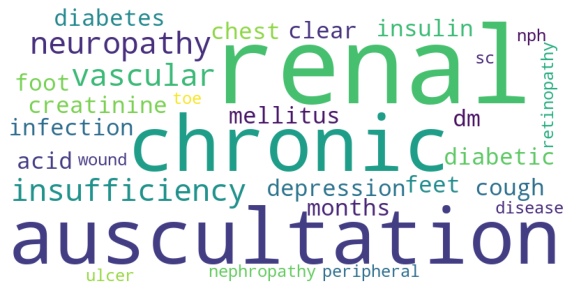

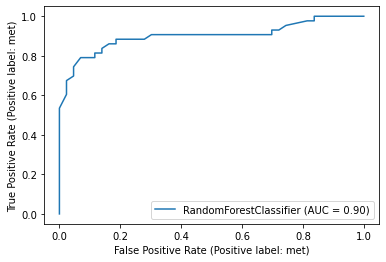

F1 score Traning Dataset using 3 Fold CV: 0.9
F1 score Testing Dataset: 0.85
not met    113
met        113
Name: Outcome, dtype: int64


In [134]:
# Here we are using the criteira prediction model for Major-diabetes 
Criteria_prediction('/Users/kavanp/Downloads/train','/Users/kavanp/Downloads/n2c2-t1_gold_standard_test_data/test','MAJOR-DIABETES')

In [ ]:
# Plot bubble graph for individual patient
# this bubble graph function require patient id as an input for plotting it. 
def bubble_graph(p_number):    
    import plotly.graph_objs as go
    sz = Normal_Test_Matrix[p_number]
    sz = sz.tolist()[0]
    new_sz = []
    Name_tag = []
    imprt = []
    idx = 0
    for i in tqdm(sz):
        if (i > 0):
            new_sz.append((i)*1000+40)
            Name_tag.append(List_of_selected_words[idx])
            imprt.append('Significent')
        else:
            new_sz.append(i*1000+10)
            Name_tag.append('')
            imprt.append('Not Significent')
        idx = idx+1
    fig = go.Figure(data=[go.Scatter(y=sz,
                                     x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],text=Name_tag,textposition='top center',
        mode='markers+text',marker=dict(size=new_sz))
    ])
    fig.update_traces(marker=dict(size=new_sz,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers+text'))
    fig.show()

In [ ]:
# here we are plotting the bubble graph for patient id 1 for major diabetes criteria
bubble_graph(1)